
Transfer Learning
***

In this notebook, you will learn how to use language models in scenarios where labeled training data is limited. You may find that, for a given language or domain, there is no dataset of suitable size. Transfer learning allows us to apply the latent information learned by models trained in high resource languages or domains to downstream tasks without the need for a lot of task-specific annotated data.

* First, you will experiment with in-context learning. Here the task description and a varying amount of training examples is passed to the model alongside the actual input while making predictions.
* Second, you will learn how to use a model that is trained on one language to make predictions for data in another language.


In [1]:
!pip install seqeval rouge -q --root-user-action=ignore

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, logging
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from datasets import load_dataset, load_metric
from sklearn.metrics import f1_score
from random import randrange
from pprint import pprint
from rouge import Rouge
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import numpy as np
import torch
import re

metric = load_metric("seqeval")
logging.set_verbosity_error()
tqdm.pandas()

## Task 1: Transfer Learning

Transfer learning allows a model to be trained on data from a source setting and applied to a different target setting. The model we want to use is trained on English text. We will fine-tune it with texts in the target language to use it with text in a different language. The model should be able to use some of the latent information learned during pretraining. Settings involving low resource languages with not enough data available to properly pretrain do especially benefit from such an approach.

**Named Entity Recognition as Seq-to-Seq Problem:**

NER is commonly modeled as a token classification task using sequence-to-sequence models. The commonly used IOB notation accounts for multi-token entities by labeling them as either the beginning of an entity (B) or the inside token of an entity (I). Non-entity tokens are labeled as O. Extending this notation by adding the abbreviated entity type as a suffix to form a joint label is common. Examples are B-PER for the beginning of a person or I-LOC for an inside token of a location’s name.


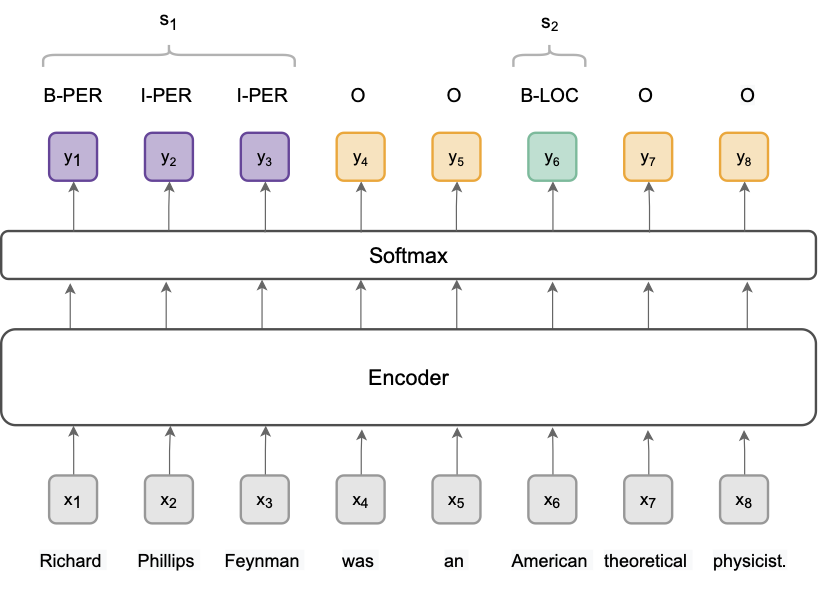


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Fine-tune a Model</b> 
</div>

First, we want to obtain a performance baseline by measuring how well a model which was pretrained and fine-tuned with English data performs. Please implement the following tasks:

1. Load the [roberta-base](https://huggingface.co/roberta-base) model and tokenizer. 
2. Load the English portion of the [europarl dataset](https://www.kaggle.com/datasets/julianschelb/euro-parl-ner).
3. Tokenize the train and test set.
4. Fine-tune the model for token classification using the train set, by completing the provided functions.
    * Use the [AutoTokenizer()](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) and  [AutoModelforTokenClassification()](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification) classes provided by the transformers package. 
    * You can use this [example](https://github.com/julianschelb/roberta-ner-multilingual) implementation as a guide. Train for at least 4 epochs.
5. Use the test set to evaluate the models' performance.
6. Report the model's performance by printing the f1 score.


In [3]:
# Mapping from class name to class ID
label_ids = {"O": 0, "B-ORG": 1, "I-ORG": 2, 
             "B-PER": 3, "I-PER": 4, 
             "B-LOC": 5, "I-LOC": 6, 
             "B-MISC": 7, "I-MISC": 8}

# Mapping from class ID to class Iname
label_names = {0: "O", 1: "B-ORG", 2: "I-ORG",  
               3: "B-PER", 4: "I-PER" , 
               5: "B-LOC", 6: "I-LOC",  
               7: "B-MISC", 8: "I-MISC"}

In [4]:
# Load dataset
dataset_train = load_dataset("json", data_files="/kaggle/input/euro-parl-ner/en-europarl_iob_train.jsonl", split = "train")
dataset_test = load_dataset("json", data_files="/kaggle/input/euro-parl-ner/en-europarl_iob_test.jsonl", split = "train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-c2183ee279055f19/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-b9c482aab883fe1c/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


In [5]:
dataset_train

Dataset({
    features: ['tokens', 'labels'],
    num_rows: 500
})

In [6]:
# Load the model & tokenizer
model_name='roberta-base'
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=9)
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [7]:
# Tokenize the dataset

def tokenizeInputs(inputs):
    
    tokenized_inputs = tokenizer(inputs["tokens"], max_length = 256, truncation=True, is_split_into_words=True, add_special_tokens=False)
    word_ids = tokenized_inputs.word_ids()
    ner_tags = inputs["labels"]
    labels = [ner_tags[word_id] for word_id in word_ids]
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

dataset_train = dataset_train.map(tokenizeInputs)
dataset_test = dataset_test.map(tokenizeInputs)

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/268 [00:00<?, ?ex/s]

In [8]:
print("Tokens:\n", dataset_train[0].get("tokens"), end = "\n\n")
print("Input IDs:\n", dataset_train[0].get("input_ids"), end = "\n\n")
print("Labels:\n", dataset_train[0].get("labels"), end = "\n\n")

Tokens:
 ['Resumption', 'of', 'the', 'session', 'I', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'European', 'Parliament', 'adjourned', 'on', 'Friday', '17', 'December', '1999', ',', 'and', 'I', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period', '.']

Input IDs:
 [4787, 21236, 9, 5, 1852, 38, 10152, 13168, 5, 1852, 9, 5, 796, 3879, 16649, 196, 15, 273, 601, 719, 6193, 2156, 8, 38, 74, 101, 683, 456, 7, 2813, 47, 10, 1372, 92, 76, 11, 5, 1034, 14, 47, 3776, 10, 16219, 12298, 675, 479]

Labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [9]:
# Fine-tune the Model

def finetuneModel(tokenizer, model, dataset_train, epochs=2):
    
    # Define data collator
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

    # Set hyperparameters
    training_args = TrainingArguments(
        output_dir="./results",
        logging_strategy="steps",
        logging_steps=50,
        per_device_train_batch_size=8,
        num_train_epochs=epochs,
        report_to="none",
        #fp16=True,
        optim="adamw_torch"
    )

    # Define trainer object
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_train,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # Fine-tune model
    trainer.train()

    return model, trainer


model, trainer = finetuneModel(tokenizer, model, dataset_train, 8)

The following columns in the training set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens. If tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 500
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 504


{'loss': 0.2984, 'learning_rate': 4.503968253968254e-05, 'epoch': 0.79}
{'loss': 0.1215, 'learning_rate': 4.007936507936508e-05, 'epoch': 1.59}
{'loss': 0.0775, 'learning_rate': 3.511904761904762e-05, 'epoch': 2.38}
{'loss': 0.0421, 'learning_rate': 3.0158730158730158e-05, 'epoch': 3.17}
{'loss': 0.0327, 'learning_rate': 2.5198412698412697e-05, 'epoch': 3.97}
{'loss': 0.0252, 'learning_rate': 2.023809523809524e-05, 'epoch': 4.76}
{'loss': 0.0171, 'learning_rate': 1.527777777777778e-05, 'epoch': 5.56}
{'loss': 0.0098, 'learning_rate': 1.0317460317460318e-05, 'epoch': 6.35}
{'loss': 0.0062, 'learning_rate': 5.357142857142857e-06, 'epoch': 7.14}


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json


{'loss': 0.0052, 'learning_rate': 3.9682539682539683e-07, 'epoch': 7.94}


Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 50.0969, 'train_samples_per_second': 79.845, 'train_steps_per_second': 10.061, 'train_loss': 0.0632936515594049, 'epoch': 8.0}


In [10]:
# Evaluate the model using the test set

def getPredictions(trainer, dataset_test):
    predictions, labels, _ = trainer.predict(dataset_test)
    predictions = np.argmax(predictions, axis=-1)
    return predictions, labels

predictions, labels = getPredictions(trainer, dataset_test)

The following columns in the test set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens. If tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 268
  Batch size = 8


In [11]:
labels[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    5,    0, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100])

In [12]:
predictions[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [13]:
# Calculate performance metrics

def calculateMetrics(labels, predictions, label_names):
    # Extact true labels
    true_labels = [
        [label_names[l] for l in label  if l != -100] 
        for label in labels
    ]

    # Extact predicted labels
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label)  if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Calculate metrics
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return results

results_en = calculateMetrics(labels, predictions, label_names)
pprint(results_en)

{'LOC': {'f1': 0.8529411764705882,
         'number': 34,
         'precision': 0.8529411764705882,
         'recall': 0.8529411764705882},
 'MISC': {'f1': 0.449438202247191,
          'number': 86,
          'precision': 0.43478260869565216,
          'recall': 0.46511627906976744},
 'ORG': {'f1': 0.834862385321101,
         'number': 108,
         'precision': 0.8272727272727273,
         'recall': 0.8425925925925926},
 'PER': {'f1': 0.6408839779005525,
         'number': 66,
         'precision': 0.5043478260869565,
         'recall': 0.8787878787878788},
 'overall_accuracy': 0.9747481029978853,
 'overall_f1': 0.6759689922480621,
 'overall_precision': 0.6210826210826211,
 'overall_recall': 0.7414965986394558}


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Fine-Tune With a Different Language</b> 
</div>

Finally, we test how well the model performs for similar languages. Your task is to fine-tune the model with one of the other languages included in the dataset. You can choose between the Italian, Spanish or German portion of the [europarl dataset](https://www.kaggle.com/datasets/julianschelb/euro-parl-ner). You can reuse the code from the previous step. Please report the f1 score as well.

* How does the model perform even though it was trained on a different language? 
* Was the model  able to transfer some of the information learned during pretraining?


In [14]:
# Load datasets
dataset_train = load_dataset("json", data_files="/kaggle/input/euro-parl-ner/de-europarl_iob_train.jsonl", split = "train")
dataset_test = load_dataset("json", data_files="/kaggle/input/euro-parl-ner/de-europarl_iob_test.jsonl", split = "train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9357a8bafc91065c/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-96839dc943111a50/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


In [15]:
# Tokenize the dataset
dataset_train = dataset_train.map(tokenizeInputs)
dataset_test = dataset_test.map(tokenizeInputs)

# Fine-tune the model
model, trainer = finetuneModel(tokenizer, model, dataset_train, 8)

# Evaluate the model using the test set
predictions, labels = getPredictions(trainer, dataset_test)

# Calculate performancr metrics
results_de = calculateMetrics(labels, predictions, label_names)
pprint(results_de)

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/283 [00:00<?, ?ex/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens. If tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 500
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 504


Step,Training Loss
50,0.267200
100,0.135700
150,0.113300
200,0.072400
250,0.056900
300,0.034600
350,0.023100
400,0.024600
450,0.011700
500,0.009400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens. If tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 283
  Batch size = 8


{'LOC': {'f1': 0.6490066225165563,
         'number': 71,
         'precision': 0.6125,
         'recall': 0.6901408450704225},
 'MISC': {'f1': 0.4665629860031104,
          'number': 383,
          'precision': 0.5769230769230769,
          'recall': 0.391644908616188},
 'ORG': {'f1': 0.746705710102489,
         'number': 336,
         'precision': 0.7348703170028819,
         'recall': 0.7589285714285714},
 'PER': {'f1': 0.5492957746478873,
         'number': 74,
         'precision': 0.5735294117647058,
         'recall': 0.527027027027027},
 'overall_accuracy': 0.9599863783415631,
 'overall_f1': 0.609017912291538,
 'overall_precision': 0.6529801324503312,
 'overall_recall': 0.5706018518518519}


**Your Interpretation:**

The high accuracy indicates that the model was able to adapt to the new language and reuse at least some of the syntactical and semantic information learned from the English corpus.

***

## Task 2: In-Context Learning

Training a model is difficult in many supervised Machine Learning applications due to the limited amount of labeled data.  It's possible to work around this limitation by not fine-tuning a model at all, but including the task description along with a varying number of training examples as context while making predictions (as demonstrated in ["Language Models are Few-Shot Learners"](https://arxiv.org/pdf/2005.14165.pdf)). The assumption is that the model can infer the task from the included context without being fine-tuned for that specific task. Depending on how many training examples are included in the context, we distinguish between three scenarios:

* **Zero-Shot (0S)**: only the task description and no training examples are included.
* **One-Shot (1S)**: a single training example is included.
* **Few-Shot (FS)**: k training examples are included (usually k < 100).

This article about ["Few-shot learning in practice"](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api) provides more background information and an interactive web demonstration.



<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load Dataset and Model</b> 
</div>

For this assignment, we will use a dataset created to evaluate models for Named Entity Recognition (NER). NER is the task of identifying real-world entities in free text and labeling them as one out of a set of predefined entity types (e.g., persons, organizations, locations). The [original corpus](https://aclanthology.org/2005.mtsummit-papers.11/) consists of parallel text from the proceedings of the European Parliament in multiple languages. Here we use an [annotated version](https://aclanthology.org/L18-1557/) where entities are already tagged.

Please implement the following tasks:
1. Import the csv file "en-europarl.csv" from [this dataset](https://www.kaggle.com/datasets/julianschelb/euro-parl-ner), which contains sentences with entities already tagged.
2. Load the [FLAN-T5-large ](https://huggingface.co/google/flan-t5-large) model, which we will use in subsequent tasks.


In [16]:
# Load the dataset
data = pd.read_csv("/kaggle/input/euro-parl-ner/en-europarl.csv")
data.head()

,sentence,type,label
0,Resumption of the session I declare resumed th...,organization,European Parliament
1,"In the meantime , I should like to observe a m...",organization,European Union
2,( The House rose and observed a minute ' s sil...,organization,House
3,You will be aware from the press and televisio...,location,Sri Lanka
4,"If the House agrees , I shall do as Mr Evans h...",person,Evans


In [17]:
# Check if GPU is available 
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

# Otherwise use the CPU
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [18]:
# Load the model & tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large").to(device)

https://huggingface.co/google/flan-t5-large/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpuvu7ru2a


Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

storing https://huggingface.co/google/flan-t5-large/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/1fe360ce7fed8618613f254ed63ef7ce6b6c312a391c606535a1844496d16965.762c37c9cc99ce7fb5e0e38232f48ac55068f2f30494cc37ed5799882ce02a9e
creating metadata file for /root/.cache/huggingface/transformers/1fe360ce7fed8618613f254ed63ef7ce6b6c312a391c606535a1844496d16965.762c37c9cc99ce7fb5e0e38232f48ac55068f2f30494cc37ed5799882ce02a9e
https://huggingface.co/google/flan-t5-large/resolve/main/spiece.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpsn28rn7x


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

storing https://huggingface.co/google/flan-t5-large/resolve/main/spiece.model in cache at /root/.cache/huggingface/transformers/505457a25cf58840d40293f753a52c46118e3283005a247dd62c9aa580e792cf.d6f0605ae3d57070be74b4c12206072ab332922acff822e6b5458691dbda7551
creating metadata file for /root/.cache/huggingface/transformers/505457a25cf58840d40293f753a52c46118e3283005a247dd62c9aa580e792cf.d6f0605ae3d57070be74b4c12206072ab332922acff822e6b5458691dbda7551
https://huggingface.co/google/flan-t5-large/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpghs0_3lw


Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

storing https://huggingface.co/google/flan-t5-large/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/fc4d61fd3eaac42cbbd00418a56c6690d2c09549d12c2f42280179e71c6b7c28.1d3a9d7a332839b438f0d489ad98892ef82082982cdf2adddc251c880c7935c9
creating metadata file for /root/.cache/huggingface/transformers/fc4d61fd3eaac42cbbd00418a56c6690d2c09549d12c2f42280179e71c6b7c28.1d3a9d7a332839b438f0d489ad98892ef82082982cdf2adddc251c880c7935c9
https://huggingface.co/google/flan-t5-large/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp8ln1wmjk


Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

storing https://huggingface.co/google/flan-t5-large/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/badc2eaf3223da96073d5f57e3d9574d854833647cd297758b70b89931e0e415.a6ade5be9ee4d179c3ae03f26ae924a8473ffd7fc4b15c73138dcc1527b00e62
creating metadata file for /root/.cache/huggingface/transformers/badc2eaf3223da96073d5f57e3d9574d854833647cd297758b70b89931e0e415.a6ade5be9ee4d179c3ae03f26ae924a8473ffd7fc4b15c73138dcc1527b00e62
loading file https://huggingface.co/google/flan-t5-large/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/505457a25cf58840d40293f753a52c46118e3283005a247dd62c9aa580e792cf.d6f0605ae3d57070be74b4c12206072ab332922acff822e6b5458691dbda7551
loading file https://huggingface.co/google/flan-t5-large/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/fc4d61fd3eaac42cbbd00418a56c6690d2c09549d12c2f42280179e71c6b7c28.1d3a9d7a332839b438f0d489ad98892ef82082982cdf2adddc251c880c7935c9
load

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

storing https://huggingface.co/google/flan-t5-large/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/5b866a94a720960b86a8bb4ad226aa146e9b6fd2d770d8d96b5c01d722f99230.13075727bd61cbbe7b4201e55542977a58959e8e6592f13a331892d4e94897a4
creating metadata file for /root/.cache/huggingface/transformers/5b866a94a720960b86a8bb4ad226aa146e9b6fd2d770d8d96b5c01d722f99230.13075727bd61cbbe7b4201e55542977a58959e8e6592f13a331892d4e94897a4
loading configuration file https://huggingface.co/google/flan-t5-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/5b866a94a720960b86a8bb4ad226aa146e9b6fd2d770d8d96b5c01d722f99230.13075727bd61cbbe7b4201e55542977a58959e8e6592f13a331892d4e94897a4
Model config T5Config {
  "_name_or_path": "google/flan-t5-large",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_toke

Downloading:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

storing https://huggingface.co/google/flan-t5-large/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/37a32a23e7f37b79a48cd1ae83a00d2fb02f7a4efc136b4572ab0b3d57d9d44b.9f1cc2456741ce458b0c02075539fb4afdd84c4b23b6bd40f8a410e20ecb7e0d
creating metadata file for /root/.cache/huggingface/transformers/37a32a23e7f37b79a48cd1ae83a00d2fb02f7a4efc136b4572ab0b3d57d9d44b.9f1cc2456741ce458b0c02075539fb4afdd84c4b23b6bd40f8a410e20ecb7e0d
loading weights file https://huggingface.co/google/flan-t5-large/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/37a32a23e7f37b79a48cd1ae83a00d2fb02f7a4efc136b4572ab0b3d57d9d44b.9f1cc2456741ce458b0c02075539fb4afdd84c4b23b6bd40f8a410e20ecb7e0d
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at google/flan-t5-large.
If your task is similar to the task the model of the checkpoint 

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Context Construction</b> 
</div>

Your task is to implement a function which uses the non-fine-tuned [FLAN-T5-large ](https://huggingface.co/google/flan-t5-large) to detect named entities in a given sentence. To achieve this, you need to construct the input sequence by combining $k$ complete training examples and the final incomplete example for the model to predict. 

Please complete the function *constructContext()* which ...

* takes as paramater a sentence, the entity type, and $k$ (number of training examples).
* returns the constructed context.

The final input sequence should be constructed as follows:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 658px">
<colgroup>
<col style="width: 201px">
<col style="width: 457px">
</colgroup>
<thead>
  <tr>
    <th class="tg-0pky">Section</th>
    <th class="tg-0pky">Example Value</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">k Complete Training Examples</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">C: I should be very grateful , Mrs Schroedter , if you would actually include this proposed amendment. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What person is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A: Schroedter</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">###</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">C: Mr Bernié is not to blame for this as it was a matter for the previous committee. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What person is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A: Bernié</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">###</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">C: The Commission must track down the illegal aid. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What organization is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A: Commission</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">###</span><br></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">Incomplete Example</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">C: I should like to observe a minute ' s silence , on behalf of all the victims in the the European Union. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What organization is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A:</span><br></td>
  </tr>
</tbody>
</table>


In [19]:
# Complete this function
def constructContext(k, sentence, entity_type, **kwargs) -> str:
    """Returns the input sequence for in-context learning."""
    
    context = ""
    
    # Add examples to context 
    for i in range(k):
        example = data.iloc[randrange(data.shape[0])] 
        context += "C: " + example["sentence"] + "\n"
        context += "Q: " + "What " + example["type"] + " is mentioned?" + "\n"
        context += "A: " + example["label"] + "\n"
        context += "###\n"
        
    # Add incomplete example to context 
    context += "C: " + sentence + "\n"
    context += "Q: " + "What " + entity_type + " is mentioned?" + "\n"
    context += "A:" 
    
    return(context)

In [20]:
# Test your implementation
context = constructContext(3, data.iloc[3]["sentence"], data.iloc[3]["type"])
print(context)

C: Mr President , Commissioner , in the course of this pivotal year , prior to the changeover to the single currency , the Commission has deployed every effort to ensure the birth of the euro in a favourable environment . 
Q: What organization is mentioned?
A: Commission
###
C: The traffic which had to be diverted because of this stretched the patience of many thousands of people in the EU to the limit . 
Q: What location is mentioned?
A: EU
###
C: Thank you , Mr Segni , I shall do so gladly . 
Q: What person is mentioned?
A: Segni
###
C: You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka . 
Q: What location is mentioned?
A:


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Named Entity Recognition</b> 
</div>

By passing the constructed context to GPT-NEO, the model should be able to infer that the entity in the last incomplete example is the desired next token to generate. The examples provided in the [model card](https://huggingface.co/google/flan-t5-large) and the [documentation](https://huggingface.co/docs/transformers/model_doc/t5) on huggingface.co should be helpful resources. 

Please complete the function *predictEntity()* which ...

* takes a constructed context as parameter,
* generates n additional tokens (e.g. by using the [.generate()](https://huggingface.co/docs/transformers/main_classes/text_generation) method),
* extracts the answer from the generated text,
* and finally returns the answer predicted by the model.

In [21]:
def predictEntity(context, max_new_tokens = 2):
    """Identifies entities using in-context learning."""

    # Tokenize context
    input_sequence = tokenizer(context, return_tensors="pt")
    
    # Generate answer using generate() 
    gen_tokens = model.generate(
         **input_sequence.to(device),
         pad_token_id = model.config.eos_token_id,
         do_sample=False,
         temperature=0.9,
         max_new_tokens=max_new_tokens,
     )

    gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens = True)
    prediction = gen_text[0].strip()
    if "###" in prediction:
        prediction = prediction[ 0 : prediction.index("###")].strip()

    return prediction

In [22]:
prediction = predictEntity(context)
print("Prediction:", prediction)
print("True Answer:", data.iloc[3]["label"])

Prediction: Sri Lanka
True Answer: Sri Lanka


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Evaluate the Model’s In-Context Learning Performance</b> 
</div>

Your next task is to evaluate the model's performance in different in-context learning scenarios. Please implement the following steps:

1. Evaluate the model in a Zero-Shot (k = 0), One-Shot (k = 1) and Few-Shot (k = 3) scenario:
    * First, construct contexts using *constructContext()*.
    * Second, pass the contexts to *predictEntity()* to obtain the answer.
2. Display 10 results for each of the three scenarios.
3. Calculate the [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) and [ROUGE-L](https://pypi.org/project/rouge/) score for each of the three scenarios. 
4. Plot the results with k as x-axis and f1 score as y-axis and briefly summarize the results.

In [23]:
# Evaluate with k = 0

data['cotext_0s'] = data.progress_apply(
    lambda task: constructContext(0, task["sentence"], task["type"]), axis=1
).copy()

data['prediction_0s'] = data.progress_apply(
    lambda task: predictEntity(task['cotext_0s'], 5), axis=1
).copy()

100%|██████████| 193/193 [00:20<00:00,  9.22it/s]


In [24]:
# Print 10 results for k = 0
data[["cotext_0s", "prediction_0s", "label"]].head(10)

,cotext_0s,prediction_0s,label
0,C: Resumption of the session I declare resumed...,European Parliament,European Parliament
1,"C: In the meantime , I should like to observe ...",European Union,European Union
2,C: ( The House rose and observed a minute ' s ...,The House,House
3,C: You will be aware from the press and televi...,(iv),Sri Lanka
4,"C: If the House agrees , I shall do as Mr Evan...",Mr Evans,Evans
5,C: We shall call him Mr Hicks . \nQ: What pers...,a man,Hicks
6,"C: Thank you , Mr Segni , I shall do so gladly...",Mr Segni,Segni
7,"C: Indeed , it is quite in keeping with the po...",The House,House
8,C: All of us here are pleased that the courts ...,Russia,Russia
9,"C: We know , and we have stated as much in ver...",Alexander Nikitin,Alexander Nikitin


In [25]:
# Evaluate with k = 1

data['cotext_1s'] = data.progress_apply(
    lambda task: constructContext(1, task["sentence"], task["type"]), axis=1
).copy()

data['prediction_1s'] = data.progress_apply(
    lambda task: predictEntity(task['cotext_1s'], 5), axis=1
).copy()

100%|██████████| 193/193 [00:20<00:00,  9.49it/s]


In [26]:
# Print 10 results for k = 0
data[["cotext_1s", "prediction_1s", "label"]].head(10)

,cotext_1s,prediction_1s,label
0,"C: But these are competitive jobs , for this s...",European Parliament,European Parliament
1,C: These amendments also fit in with this Parl...,European Union,European Union
2,"C: We have referred to the delay by the CEN , ...",The House,House
3,C: I would like to ask the Vice-President if s...,Sri Lanka,Sri Lanka
4,C: The ever increasing volume of goods passing...,Mr Evans,Evans
5,"C: I often have the impression , unlike the co...",Mr Hicks,Hicks
6,"C: Madam President , I do not wish to reopen t...",Mr Segni,Segni
7,"C: If it functions well , if we are satisfied ...",House of Representatives,House
8,"C: But these are competitive jobs , for this s...",Russia,Russia
9,C: The Commission has put forward a new White ...,Alexander Nikitin,Alexander Nikitin


In [27]:
# Evaluate with k = 3

data['cotext_fs'] = data.progress_apply(
    lambda task: constructContext(3, task["sentence"], task["type"]), axis=1
).copy()

data['prediction_fs'] = data.progress_apply(
    lambda task: predictEntity(task['cotext_fs'], 5), axis=1
).copy()

100%|██████████| 193/193 [00:29<00:00,  6.60it/s]


In [28]:
# Print 10 results for k = 3
data[["cotext_fs", "prediction_fs", "label"]].tail(10)

,cotext_fs,prediction_fs,label
183,C: This has been an ongoing concern for the fi...,EU,EU
184,"C: Commissioner , please read the opinion of t...",House of Lords #,House
185,C: I wish to express that view even if I respe...,Mrs Randzio-,Randzio-Plath
186,C: A Council regulation that is directly appli...,Mr Jonckheer,Jonckheer
187,C: The state hand must still be clearly seen t...,Basque Country,Basque Country
188,"C: Thank you , Mr Segni , I shall do so gladly...",Germany,East Germany
189,"C: Following on from this , it is probably als...",Germany,Federal Republic of Germany
190,C: The amendment to the directive on today 's ...,European Union,European Union
191,"C: Mr President , I would like to say a few wo...",Europe,Europe
192,C: It has to be conceded that the EU has alrea...,Commission,Commission


In [29]:
# Calulate F1 score for 0S, 1S and FS
score_0s = f1_score(data["label"], data["prediction_0s"], average = "micro")
score_1s = f1_score(data["label"], data["prediction_1s"], average = "micro")
score_fs = f1_score(data["label"], data["prediction_fs"], average = "micro")

In [30]:
# Plot F1 scores 
k_axis = ["Zero-Shot", "One-Shot", "Few-Shot"]
scores = [score_0s, score_1s, score_fs]
fig = px.bar(x=k_axis, y=scores, labels={
                     "k_axis": "k examples",
                     "scores": "f1 score",
                 },)
fig.show()

In [31]:
# Calculate ROUGE-L for each set of predictions

predictions = [data["prediction_0s"], data["prediction_1s"], data["prediction_fs"]]
labels = data["label"]

rouge = Rouge()
rouge_l_scores = [rouge.get_scores(preds, labels, avg=True)["rouge-l"] for preds in predictions]

# Extract ROUGE-L scores
score_0s_rouge_l = rouge_l_scores[0]
score_1s_rouge_l = rouge_l_scores[1]
score_fs_rouge_l = rouge_l_scores[2]

# Print the ROUGE-L scores
print("ROUGE-L Score for 0s: ", score_0s_rouge_l)
print("ROUGE-L Score for 1s: ", score_1s_rouge_l)
print("ROUGE-L Score for Fs: ", score_fs_rouge_l)


ROUGE-L Score for 0s:  {'r': 0.7645077720207253, 'p': 0.5819516407599309, 'f': 0.6372855086773768}
ROUGE-L Score for 1s:  {'r': 0.855181347150259, 'p': 0.7375647668393782, 'f': 0.7700580896502887}
ROUGE-L Score for Fs:  {'r': 0.8810880829015543, 'p': 0.8033678756476683, 'f': 0.8187627526996274}


In [32]:
# Create separate lists for recall, precision, and f-measure
recalls = [score_0s_rouge_l['r'], score_1s_rouge_l['r'], score_fs_rouge_l['r']]
precisions = [score_0s_rouge_l['p'], score_1s_rouge_l['p'], score_fs_rouge_l['p']]
f_measures = [score_0s_rouge_l['f'], score_1s_rouge_l['f'], score_fs_rouge_l['f']]

# Create a DataFrame for plotting
df = pd.DataFrame({
    'k examples': ['Zero-Shot', 'One-Shot', 'Few-Shot'] * 3,
    'Metric': ['Recall'] * 3 + ['Precision'] * 3 + ['F-Measure'] * 3,
    'Score': recalls + precisions + f_measures
})

# Plot the data
fig = px.bar(df, x='k examples', y='Score', color='Metric', barmode='group',
             labels={"Score": "ROUGE-L Score"},
             title="ROUGE-L Scores for Different Shots")
fig.show()

**Your Interpretation:**

The model struggles in a zero-shot scenario. But the performance increases with more examples provided. The model is able to learn the task description from the provided context. For example, the model learned to signal the end of the answer in the same way it was done in the examples. 